In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

In [2]:
V1 = 33
H1 = 40
V2 = H1
H2 = 4

FF_IN = H2

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

USE_CUDA = False

In [58]:
def read_data():
    used_data = pd.read_csv('data/future_data.csv', index_col=0, parse_dates=True)

    # Prices and returns
    S = np.exp(used_data.fillna(0)).cumprod()
    ret_day = used_data.fillna(0)
    ret_mon = S.resample('1BM').ffill().pct_change()
    ret_mon['median_t+1'] = ret_mon.median(1).shift(-1)
    ret_mon = ret_mon.dropna()

    # 1 for winner, 0 for loser
    labels = ret_mon[ret_mon.columns[:-1]].gt(ret_mon['median_t+1'], axis=0).astype(int)
    ret_mon['JAN'] = (ret_mon.index.month == 1).astype(int)
    ret_mon = ret_mon.reset_index()

    # update column names after index reset
    cols = ret_mon.columns.values
    cols[0] = 'date'
    ret_mon.columns = cols
    return labels, ret_mon, ret_day, used_data

def get_data(limit_tic=None):
    labels, ret_mon, ret_day, used_data = read_data()
    
    final_data = []
    if limit_tic:
        tickers = [limit_tic]
    else:
        tickers = used_data.columns
    for tic in tickers:
        daily = ret_day[tic]
        dfs = []
        for t in range(13, len(ret_mon)-1):
            current_y = ret_mon['date'].iloc[t].year
            current_mon = ret_mon['date'].iloc[t].month

            start = t - 13
            end = t - 2

            ret_mon_slice = ret_mon[tic].iloc[start:end+1]
            ret_mon_next = ret_mon[tic].iloc[t+1]
            jan = ret_mon.JAN.iloc[t]
            label = labels[tic].iloc[t]

            last_date = (daily[(daily.index.year == current_y) 
                               & (daily.index.month == current_mon)].last_valid_index())

            last_date_loc = daily.index.get_loc(last_date)
            start_date_loc = last_date_loc - 19

            daily_rets_slice = daily.iloc[start_date_loc:last_date_loc + 1]

            daily_rets_slice.index = ['R_d_' + str(i) for i in range(1, 21)]
            ret_mon_slice.index = ['R_m_' + str(i) for i in range(1, 13)]

            conc = pd.concat([daily_rets_slice, ret_mon_slice])
            conc['jan'] = jan
            conc['label'] = label
            conc['n_return'] = ret_mon_next
            conc = conc.to_frame()
            conc.columns = [t]
            dfs.append(conc)
        feats = pd.concat(dfs, axis=1).T
        final_data.append(feats)
        
    return pd.concat(final_data, axis=0)

In [5]:
def data_importer(fname, train_set_size=0.75):
    data = get_data()
    X = data[data.columns[:-2]].as_matrix()
    y = data.label.as_matrix()
    
    N = len(y)
    train_set_stop = int(N * train_set_size)
    
    return X[0:train_set_stop], y[0: train_set_stop], X[train_set_stop:], y[train_set_stop:]

In [6]:
class FutureDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
class RBM(nn.Module):
    def __init__(self,
                 n_vis=33,
                 n_hin=40,
                 k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
    def sample_from_p(self,p):
        return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
    def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
    def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
    def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
    def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()
    
class FFNN(nn.Module):
    def __init__(self):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(H2, 50) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(50, 2)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [8]:
batch_size = 64
feature_size = 33

Xtrain, ytrain, Xtest, ytest = data_importer("./data/ES_w_features.csv")

train_dataset = FutureDataset(Xtrain, ytrain)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_dataset = FutureDataset(Xtest, ytest)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [9]:
def layer_trainer(model, optimizer, previous_models=[], num_of_epochs=10):
    print("Starting to train the model")
    for epoch in range(num_of_epochs):
        loss_ = []
        for _, (data,target) in enumerate(train_loader):
            data = Variable(data.view(-1,feature_size)).float()
            if USE_CUDA:
                model.cuda()
                data.cuda()

            for prev_model in previous_models:
                _, data = prev_model.v_to_h(data)

            v, v1 = model(data)
            loss = model.free_energy(v) - model.free_energy(v1)
            loss_.append(loss.data[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    print(f"Mean loss for EPOCH {epoch + 1}: {np.mean(loss_)}")

In [10]:
rbm = RBM(k=1, n_vis=V1, n_hin=H1)
layer_trainer(rbm, optim.SGD(rbm.parameters(), 0.1),num_of_epochs=10)

Starting to train the model
Mean loss for EPOCH 10: -0.8518569946289063


In [11]:
rbm2 = RBM(k=1,n_vis=V2, n_hin=H2)
layer_trainer(rbm2, optim.SGD(rbm2.parameters(), 0.1), [rbm], num_of_epochs=10)

Starting to train the model
Mean loss for EPOCH 10: 0.031651941935221355


In [12]:
ffnn = FFNN()

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.SGD(ffnn.parameters(), 0.01)  

In [13]:
correct = 0
total = 0
for epoch in range(10):
        loss_ = []
        for _, (data,target) in enumerate(train_loader):
            data = Variable(data.view(-1,feature_size)).float()
            labels = Variable(target).type(torch.LongTensor)

            for prev_model in [rbm, rbm2]:
                _, data = prev_model.v_to_h(data)
            
            outputs = ffnn(data)

            loss = criterion(outputs, labels)
            loss_.append(loss.data[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.data).sum()
print("Accuracy: ", correct/total)

Accuracy:  0.511283185840708


In [14]:
correct = 0
total = 0

for _, (data,target) in enumerate(test_loader):
    data = Variable(data.view(-1,feature_size)).float()
    labels = Variable(target).type(torch.LongTensor)

    for prev_model in [rbm, rbm2]:
        _, data = prev_model.v_to_h(data)

    outputs = ffnn(data)

    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.data).sum()

print("Accuracy: ", correct/total)

Accuracy:  0.44039735099337746


In [84]:
labels, ret_mon, ret_day, used_data = read_data()

feats = get_data("FESX")
X = feats[feats.columns[:-2]].as_matrix()
y = feats.label.as_matrix()

In [85]:
prediction_outputs = []
returns = []

for idx, observation in enumerate(X):
    data = torch.from_numpy(observation)

    data = Variable(data).float()
    for prev_model in [rbm, rbm2]:
        _, data = prev_model.v_to_h(data)

    outputs = ffnn(data)
    prediction_outputs.append(outputs.data.numpy())



Number of samples:  201
Real long count: 116.0
Predicted long count: 197


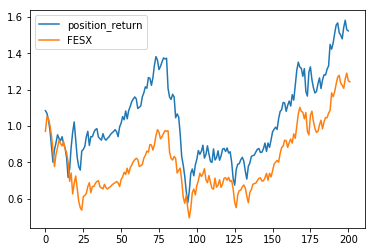

In [86]:
print("Number of samples: ", len(y))
print("Real long count:", sum(y))

result_df = pd.DataFrame(prediction_outputs, columns=["loser_p", "winner_p"])
result_df["label"] = (result_df["winner_p"] > result_df["loser_p"]).astype(int)
feats = feats.reset_index()
result_df["n_return"] = feats.n_return
result_df["longshort"] = result_df["label"].map({1: 1, 0: -1})
result_df["position_return"] = result_df["longshort"] * result_df["n_return"]

print("Predicted long count:", sum(result_df["label"]))
(result_df["position_return"] + 1).cumprod().plot(legend=True)
tmp = ret_mon.FESX.iloc[13:]
tmp = tmp.reset_index()
(tmp.FESX + 1).cumprod().plot(legend=True)




In [ ]:
result_df["label"].hist()